In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.metrics import roc_curve
import tempfile
import subprocess
import os

In [2]:
def save_fig(fig, file_name, fmt=None, dpi=300, tight=True):
    """Save a Matplotlib figure as EPS/PNG/PDF to the given path and trim it."""

    if not fmt:
        fmt = file_name.strip().split(".")[-1]

    if fmt not in ["eps", "png", "pdf"]:
        raise ValueError("unsupported format: %s" % (fmt,))

    extension = ".%s" % (fmt,)
    if not file_name.endswith(extension):
        file_name += extension

    file_name = os.path.abspath(file_name)
    with tempfile.NamedTemporaryFile() as tmp_file:
        tmp_name = tmp_file.name + extension

    # save figure
    if tight:
        fig.savefig(tmp_name, dpi=dpi, bbox_inches="tight")
    else:
        fig.savefig(tmp_name, dpi=dpi)

    # trim it
    if fmt == "eps":
        subprocess.call(
            "epstool --bbox --copy %s %s" % (tmp_name, file_name), shell=True
        )
    elif fmt == "png":
        subprocess.call("convert %s -trim %s" % (tmp_name, file_name), shell=True)
    elif fmt == "pdf":
        subprocess.call("pdfcrop %s %s" % (tmp_name, file_name), shell=True)


In [3]:
# load data from folder
def load_data(method, mode='all'):
    if method == "CAMPrints" or method == "MWDCNN":
        root_folder = "./Expected_Results/Evaluation_Results"
    elif method == "DRUNET" or method == "Wiener":
        root_folder = "./Expected_Results/Baseline_Evaluation_Results"

    adv_types = []
    if mode == 'value':
        adv_types = [1, 3, 7, 8, 9, 10]
    elif mode == 'location':
        adv_types = [2, 4, 5, 6]
    elif mode == 'both':
        adv_types = ["1_2_3_4", "7_6_8_5"]
    elif mode == 'all':
        adv_types = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, "1_2_3_4", "7_6_8_5"]
    
    y_preds = []
    y_trues = []
    for adv_type in adv_types:
        folder = root_folder + f"/overall_adv_{adv_type}/"
        if method == "Wiener":
            folder = root_folder + f"/wiener_overall_adv_{adv_type}/"
        y_pred_file_name = 'y_pred.pkl'
        y_true_file_name = 'y_true.pkl'
        if method == "DRUNET" or method == "Wiener":
            y_pred_file_name = 'baseline_scores.pkl'
            y_true_file_name = 'baseline_labels.pkl'
        if method == "MWDCNN":  
            y_pred_file_name = 'baseline_y_pred.pkl'
            y_true_file_name = 'baseline_y_true.pkl'
        with open(folder + y_pred_file_name, 'rb') as f:
            y_preds += pickle.load(f)
        with open(folder + y_true_file_name, 'rb') as f:
            y_trues += pickle.load(f)
    
    return y_preds, y_trues

In [4]:
COLORSCHEME = [
    [0.698039215686275, 0.0941176470588235, 0.168627450980392],
    [0.937254901960784, 0.541176470588235, 0.384313725490196],
    [0.129411764705882, 0.400000000000000, 0.674509803921569],
    [0.403921568627451, 0.662745098039216, 0.811764705882353],
]
LINE_MARKERS = ["o", "^", "s", "D"]
LINE_STYLES = ["-", "--", "-.", ":"]

def plot_roc_curve(list_of_data, list_of_labels):
    fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
    ax.set_axisbelow(True)
    ax.grid(axis="both", linestyle="--", alpha=0.5)

    for i in range(len(list_of_data)):
        y_pred, y_true = list_of_data[i]
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        ax.plot(fpr, tpr, label=list_of_labels[i], color=COLORSCHEME[i],
                linewidth=2, linestyle=LINE_STYLES[i])
    # draw a line indicating random guess on the ROC curve
    ax.plot([0, 1], [0, 1], color="darkgray", linewidth=1, linestyle="--")

    ax.tick_params(axis=u"both", which=u"both", direction="in", length=1.5)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xticks(np.arange(0, 1.1, 0.2))
    ax.set_yticks(np.arange(0, 1.1, 0.2))
    ax.legend()
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    fig.tight_layout()
    plt.show()
    save_fig(fig, "./overall_roc.pdf", fmt="pdf", dpi=300)

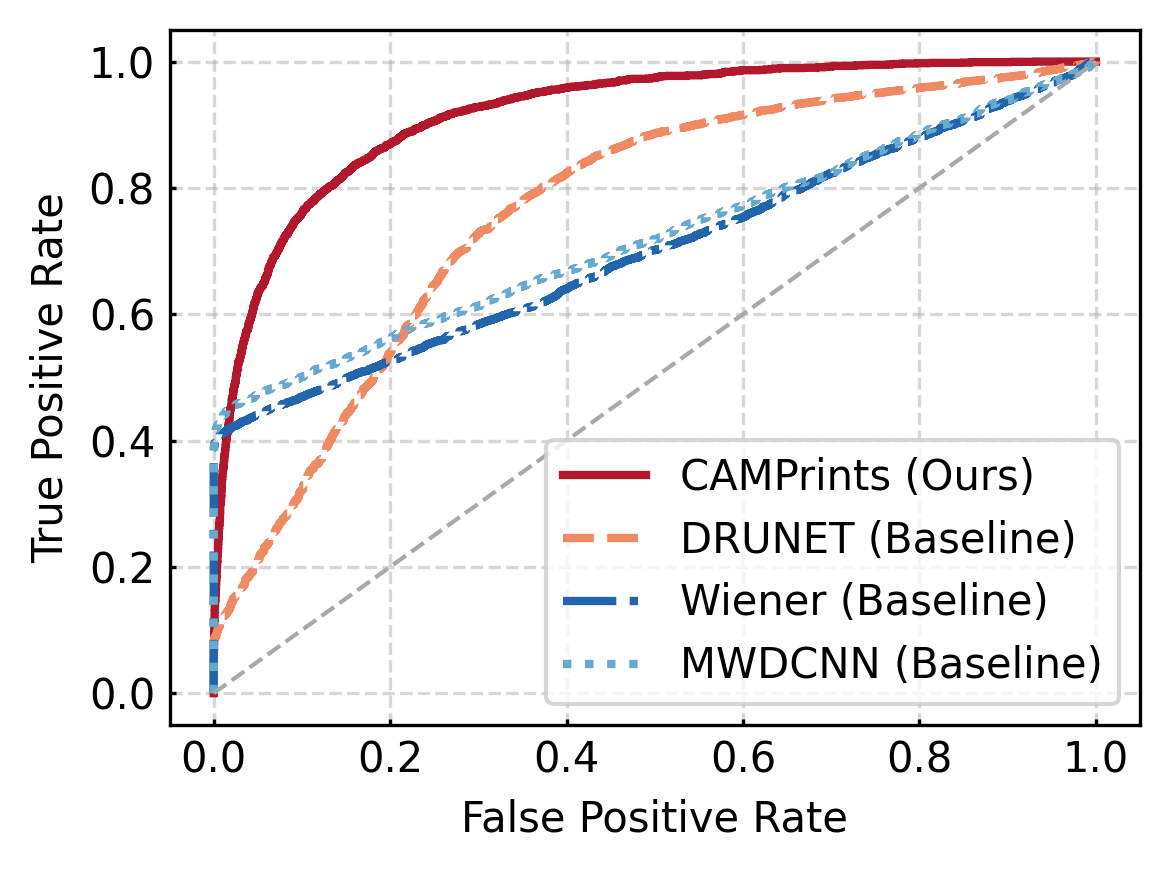

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `/home/bangjie/CamHash_v2/Paper553-Artifact/overall_roc.pdf'.


In [5]:
list_of_data = []
list_of_labels = []
for method in ["CAMPrints", "DRUNET", "Wiener", "MWDCNN"]:
    y_pred, y_true = load_data(method, mode="all")
    list_of_data.append((y_pred, y_true))
    if method == "CAMPrints":
        affix = " (Ours)"
    else:
        affix = " (Baseline)"
    list_of_labels.append(f"{method}" + affix)

plot_roc_curve(list_of_data, list_of_labels)